In [153]:
import pyspark
import timeit
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql import Row
import pyspark.sql.functions as F
import numpy as np
import matplotlib.pyplot as plt

### Data loading from filesystem

In [2]:
spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .getOrCreate()

In [3]:
prescription_schema = StructType([StructField('기준년도', IntegerType(),True),
                                 StructField('가입자일련번호', StringType(),True),
                                 StructField('처방내역일련번호', StringType(),True),
                                 StructField('일련번호', IntegerType(),True),
                                 StructField('성별코드', IntegerType(),True),
                                 StructField('연령대코드', IntegerType(),True),
                                 StructField('시도코드', StringType(),True),
                                 StructField('요양개시일자', DateType(),True),
                                 StructField('약품일반성분명코드', StringType(),True),
                                 StructField('1회투약량', FloatType(),True),
                                 StructField('1일투약량', FloatType(),True),
                                 StructField('총투여일수', FloatType(),True),
                                 StructField('단가', FloatType(),True),
                                 StructField('금액', FloatType(),True),
                                 StructField('데이터공개일자', IntegerType(),True)])

In [4]:
csv_df= spark.read.csv("*.CSV",  
                         header=True, 
                         encoding="euc_kr",
                        dateFormat="yyyyMMdd",
                        schema=prescription_schema)

In [5]:
csv_df.printSchema()

root
 |-- 기준년도: integer (nullable = true)
 |-- 가입자일련번호: string (nullable = true)
 |-- 처방내역일련번호: string (nullable = true)
 |-- 일련번호: integer (nullable = true)
 |-- 성별코드: integer (nullable = true)
 |-- 연령대코드: integer (nullable = true)
 |-- 시도코드: string (nullable = true)
 |-- 요양개시일자: date (nullable = true)
 |-- 약품일반성분명코드: string (nullable = true)
 |-- 1회투약량: float (nullable = true)
 |-- 1일투약량: float (nullable = true)
 |-- 총투여일수: float (nullable = true)
 |-- 단가: float (nullable = true)
 |-- 금액: float (nullable = true)
 |-- 데이터공개일자: integer (nullable = true)



In [6]:
csv_df.count()

79592489

In [7]:
csv_df.show(5)

+--------+--------------+----------------+--------+--------+----------+--------+------------+------------------+---------+---------+----------+-----+------+--------------+
|기준년도|가입자일련번호|처방내역일련번호|일련번호|성별코드|연령대코드|시도코드|요양개시일자|약품일반성분명코드|1회투약량|1일투약량|총투여일수| 단가|  금액|데이터공개일자|
+--------+--------------+----------------+--------+--------+----------+--------+------------+------------------+---------+---------+----------+-----+------+--------------+
|    2018|        700001|        19846989|       6|       1|         8|      45|  2018-01-05|         463601ATB|      1.0|      1.0|       5.0|210.0|1050.0|      20191217|
|    2018|        700001|        34735781|       5|       1|         8|      45|  2018-12-03|         463601ATB|      1.0|      1.0|       5.0|210.0|1050.0|      20191217|
|    2018|        700001|        33866502|       1|       1|         8|      45|  2018-07-02|         621702ATB|      1.0|      2.0|       7.0|205.0|2870.0|      20191217|
|    2018|        700001|        34735781| 

We have around 79 million rows with various potential case for data analysis. 

Next, we will try to find null values in our data

In [8]:
list_col = ['가입자일련번호','처방내역일련번호','일련번호','성별코드',
            '시도코드','요양개시일자','약품일반성분명코드']

for col_ in list_col:
    print("null values in "+col_+":"+str(csv_df.where(F.col(col_).isNull()).count()))

null values in 가입자일련번호:0
null values in 처방내역일련번호:0
null values in 일련번호:0
null values in 성별코드:0
null values in 시도코드:0
null values in 요양개시일자:0
null values in 약품일반성분명코드:5647


In [9]:
list_col = ['기준년도','성별코드','일련번호','연령대코드','1회투약량','1일투약량','총투여일수','단가',
             '금액','데이터공개일자']

for col_ in list_col:
    print("Zero values in "+col_+":"+str(csv_df.where(F.col(col_)==0).count()))

Zero values in 기준년도:0
Zero values in 성별코드:0
Zero values in 일련번호:0
Zero values in 연령대코드:0
Zero values in 1회투약량:148
Zero values in 1일투약량:67
Zero values in 총투여일수:115
Zero values in 단가:6954
Zero values in 금액:8994
Zero values in 데이터공개일자:0


We see that 약품일반성분명코드 has a some NULL rows.
Other related rows (1회투약량, 1일투약량, 총투여일수,  단가,  금액) also has some zero values (which means the medicine is free, or else).
In some analytics case, we will drop rows that have these null and zero values.

## Data analysis cases

I propose some marketing and business development-related analysis cases for the dataset. For simplicity, I only use two aggregation functions: sum and average
1. Total expenditure for prescription
3. Consumptions of medicines 
5. Length of medication 

Total expenditure analysis focuses on the money that each market spend for medicine. We will see the trends for each year based on Gender, Age group, Location, and Month/seasons.

Meanwhile, the consumptions of medicines discuss about how much each market segment consume a specific medicine. Similar to the total expenditure analysis, we will see the segment behaviour based on  Gender, Age group, Location, and Month/seasons.

The length of medication mainly describes the length of medication (possibly hospitalization) each market segment do based on the prescriptions.

### Preprocessing for data analysis case
#### 1. Expenditure

Here, I use the total expenditure for each market segment. Thus, to simplify the data processing later in visualization, I summarize the dataset into intermediate files. I will do the same thing with the other cases.

In [134]:
exp_df = csv_df.select(['성별코드','연령대코드','시도코드','요양개시일자','금액'])
exp_df = exp_df.groupBy(['성별코드','연령대코드','시도코드','요양개시일자'])\
    .agg(F.sum('금액').alias('Total_exp'))


In [135]:
exp_df.show(10)

+--------+----------+--------+------------+-----------+
|성별코드|연령대코드|시도코드|요양개시일자|  Total_exp|
+--------+----------+--------+------------+-----------+
|       1|        10|      41|  2018-06-09|  6167911.0|
|       2|        17|      46|  2018-05-10|  3353423.0|
|       2|         2|      45|  2018-12-10|   310797.0|
|       2|         1|      31|  2018-09-07|   148290.0|
|       2|         8|      41|  2018-07-26|  6656346.0|
|       2|        14|      42|  2018-11-20|  1090428.0|
|       1|        15|      26|  2018-02-21|  4610111.0|
|       2|        13|      11|  2018-05-16|1.2973176E7|
|       1|        11|      41|  2018-10-02|1.2293847E7|
|       2|        10|      41|  2018-01-02|  6270051.0|
+--------+----------+--------+------------+-----------+
only showing top 10 rows



#### 2. Consumptions of medicines


For this one, I want to focus on the top 10 consumed medicine in year 2017 and 2018. Thus, I select and filtered the main dataframe to contain only the top 10 consumed medicine in year 2017 and 2018.

In [101]:
def calc_consumption(dose,daily,num_days):
    return dose * daily * num_days

calc_consumption_double  = F.udf(lambda x,y,z: calc_consumption(x,y,z), DoubleType())
spark.udf.register("calc_consumption_double", calc_consumption_double)

cons_df = csv_df.withColumn('consumption',\
                            calc_consumption_double('1회투약량','1일투약량','총투여일수'))\
                .select(['성별코드','연령대코드','시도코드','요양개시일자',\
                        '약품일반성분명코드','consumption'])
medicine_top10 = cons_df.groupBy('약품일반성분명코드').agg(F.sum('consumption'))\
    .orderBy(F.desc('sum(consumption)')).take(10)

In [117]:
medicine_top10

[Row(약품일반성분명코드='222901ATB', sum(consumption)=36226176.75631617),
 Row(약품일반성분명코드='421001ATB', sum(consumption)=32810951.60408868),
 Row(약품일반성분명코드='438901ATB', sum(consumption)=32514595.492918123),
 Row(약품일반성분명코드='530800ASY', sum(consumption)=25916246.90626848),
 Row(약품일반성분명코드='271800ATB', sum(consumption)=25682333.858704507),
 Row(약품일반성분명코드='535000ASY', sum(consumption)=25564158.46333592),
 Row(약품일반성분명코드='186101ATB', sum(consumption)=23329382.675295293),
 Row(약품일반성분명코드='532600ASY', sum(consumption)=22754545.092887234),
 Row(약품일반성분명코드='111501ATB', sum(consumption)=21855497.46899557),
 Row(약품일반성분명코드='101430ATR', sum(consumption)=19983380.07559821)]

There is no NULL medicine that is consumed in the top 10 category. Thus, it is okay to ignore the NULL values.

In [113]:
medicine_top10_list = []
for i in range(10):
    medicine_top10_list.append(medicine_top10[i].asDict()["약품일반성분명코드"])
medicine_top10_list

['222901ATB',
 '421001ATB',
 '438901ATB',
 '530800ASY',
 '271800ATB',
 '535000ASY',
 '186101ATB',
 '532600ASY',
 '111501ATB',
 '101430ATR']

In [120]:
cons_df_top10 = cons_df.filter(cons_df.약품일반성분명코드.isin(medicine_top10_list))
cons_df_top10.show()

+--------+----------+--------+------------+------------------+-----------+
|성별코드|연령대코드|시도코드|요양개시일자|약품일반성분명코드|consumption|
+--------+----------+--------+------------+------------------+-----------+
|       1|         8|      45|  2018-12-03|         186101ATB|       10.0|
|       1|         8|      45|  2018-01-05|         186101ATB|       15.0|
|       1|         8|      45|  2018-11-20|         186101ATB|       10.0|
|       1|         8|      45|  2018-12-03|         271800ATB|       15.0|
|       1|         8|      45|  2018-11-20|         271800ATB|       15.0|
|       1|         8|      45|  2018-01-05|         271800ATB|       15.0|
|       1|         8|      45|  2018-12-10|         101430ATR|        9.0|
|       1|         6|      44|  2018-05-25|         438901ATB|       14.0|
|       1|         6|      44|  2018-05-01|         222901ATB|        9.0|
|       2|         8|      11|  2018-02-20|         438901ATB|       15.0|
|       2|         8|      11|  2018-05-01|         4

#### 3. Length of medication

I assume the length of medication is the maximum value of the medication days (총투여일수) for each person each prescription. Thus, I will group them by {성별코드,연령대코드,시도코드,요양개시일자} because as far as I preprocess the data (not shown in this file), each 처방내역일련번호 (prescription number) may have many people with different 성별코드,연령대코드,시도코드. I include 요양개시일자 for later categorization.

In [139]:
lom_df = csv_df.select(['요양개시일자','성별코드','연령대코드','시도코드','총투여일수'])
lom_df = lom_df.groupBy(['요양개시일자','성별코드','연령대코드','시도코드'])\
                .agg(F.max('총투여일수').alias('Med_days'))
lom_df.show()

+------------+--------+----------+--------+--------+
|요양개시일자|성별코드|연령대코드|시도코드|Med_days|
+------------+--------+----------+--------+--------+
|  2018-08-17|       1|        14|      11|   180.0|
|  2018-09-28|       2|        12|      48|    90.0|
|  2018-10-01|       2|        15|      41|   185.0|
|  2018-11-30|       1|        16|      41|   180.0|
|  2018-06-27|       2|         4|      41|    35.0|
|  2018-06-01|       1|        15|      41|   180.0|
|  2018-09-13|       2|        12|      41|   365.0|
|  2018-06-18|       2|        17|      28|   126.0|
|  2018-03-14|       1|         6|      27|     7.0|
|  2018-11-12|       1|         6|      41|    63.0|
|  2018-08-10|       1|        16|      31|   140.0|
|  2018-08-24|       1|        11|      41|   185.0|
|  2018-04-02|       2|        10|      47|    60.0|
|  2018-09-10|       2|         8|      41|   126.0|
|  2018-12-12|       2|         3|      36|     5.0|
|  2018-08-20|       1|        18|      41|   180.0|
|  2018-08-2

-----------------------------------

For quicker processing, we save those intermediate tables as CSV files

In [137]:
exp_df.write.csv('intermediate/expenditure')
cons_df_top10.write.csv('intermediate/medicine_top10')
lom_df.write.csv('intermediate/medication_days')

Then, I move on the visualization cases

----------------------------------------------

## Visualization

I categorize each analysis to these types: Gender, Age group, Location, and Month/seasons.
Then, I visualize each category per year and conclude some insight about them.

Let's start analyzing!

First, I create new spark app that directly works on the visualization case.

In [138]:
spark_viz = SparkSession \
    .builder \
    .appName("Visualization") \
    .getOrCreate()

Then, I define the schema for each case.

In [244]:
pres_exp_schema = StructType([StructField('성별코드', IntegerType(),True),
                                 StructField('연령대코드', IntegerType(),True),
                                 StructField('시도코드', StringType(),True),
                                 StructField('요양개시일자', DateType(),True),
                                 StructField('Total_exp', DoubleType(),True)])

pres_cons_schema = StructType([StructField('성별코드', IntegerType(),True),
                                 StructField('연령대코드', IntegerType(),True),
                                 StructField('시도코드', StringType(),True),
                                 StructField('요양개시일자', DateType(),True),
                                 StructField('약품일반성분명코드', StringType(),True),
                                 StructField('consumption', DoubleType(),True)])

pres_med_schema = StructType([ StructField('요양개시일자', DateType(),True),
                                 StructField('성별코드', IntegerType(),True),
                                 StructField('연령대코드', IntegerType(),True),
                                 StructField('시도코드', StringType(),True),
                                 StructField('Med_days', DoubleType(),True)])

In [249]:
exp_df= spark_exp.read.csv("intermediate/expenditure/*.csv",  
                         header=False, 
                         encoding="euc_kr",
                        dateFormat="yyyy-MM-dd",
                        schema=pres_exp_schema)
cons_df= spark_exp.read.csv("intermediate/medicine_top10/*.csv",  
                         header=False, 
                         encoding="euc_kr",
                        dateFormat="yyyy-MM-dd",
                        schema=pres_cons_schema)
meds_df= spark_exp.read.csv("intermediate/medication_days/*.csv",  
                         header=False, 
                         encoding="euc_kr",
                        dateFormat="yyyy-MM-dd",
                        schema=pres_med_schema)

Each analysis have the same structure:
1. Month/Seasons
2. Gender
3. Age group
4. Location

I display the analysis of those four categories in two styles: (2017+2018) and separated.

For simplicity, I create a function that converts the spark dataframe to pandas dataframe. The pandas dataframe already has a built-in matplotlib functions. So, I can display the visualization with more convenience.

In [167]:
def create_df_per__cat(spark_df,category,f_agg,agg_col,alias_):
    #pd_df_cat displays the aggregation in (2017+2018) style (not separated)
    #pd_df_cat_year displays the aggregation in separated year style
    pd_df_cat = spark_df.groupBy(category).agg(f_agg(agg_col)).toPandas()
    category.append(F.year('요양개시일자'))
    pd_df_cat_year = spark_df.groupBy(category)\
                        .agg(f_agg(agg_col)).toPandas()
    return pd_df_cat, pd_df_cat_year

In addition, I create dictionary that contains the codification of age group code, gender code, and the city/province code. The matplotlib by default cannot display hangeul characters. Thus, I use alphabet to describe each code.

In [147]:
age_code = [(1,'00-04'),(2,'05-09'),(3,'10-14'),
            (4,'15-19'),(5,'20-24'),(6,'25-29'),
            (7,'30-34'),(8,'35-39'),(9,'40-44'),
            (10,'45-49'),(11,'50-54'),(12,'55-59'),
            (13,'60-64'),(14,'65-69'),(15,'70-74'),
            (16,'75-79'),(17,'80-84'),(18,'85+')]
age_code = dict(age_code)
gender_code =  {1: 'male', 2: 'female'}
city_code = {'11':'Seoul','42':'Gangwon-do',
            '26':'Busan','43':'Chungcheongbuk-do',
            '27':'Daegu','44':'Chungcheongnam-do',
            '28':'Incheon','45':'Jeollabuk-do',
            '29':'Gwangju','46':'Jeollanam-do',
            '30':'Daejeon','47':'Gyeongsangbuk-do',
            '31':'Ulsan','48':'Gyeongsangnam-do',
            '36':'Sejong','49':'Jeju',
            '41':'Gyeongggi-do'}
city_code = dict(city_code)

### 1. Total Expenditure Case



In [207]:
exp_month, exp_month_yr = create_df_per_year_cat(exp_df,[F.month('요양개시일자')],\
                                               F.sum,'Total_exp','Total_exp')

In [208]:
exp_month.head()

,month(요양개시일자),sum(Total_exp)
0,12,4.517764e+10
1,1,4.049051e+10
2,6,3.948702e+10
3,3,4.097551e+10
4,5,4.138277e+10


In [209]:
exp_month_yr.head()

,month(요양개시일자),year(요양개시일자),sum(Total_exp)
0,7,2018,2.099426e+10
1,1,2017,1.846887e+10
2,3,2017,1.999875e+10
3,6,2018,2.022949e+10
4,3,2018,2.097676e+10


The total expenditure is very large, I will divide them by 1 million to simplify the visualization. I also rename the columns for better visualization.

In [198]:
exp_month.columns=['month','total_exp']
exp_month.total_exp = exp_month.total_exp / (1000 * 1000)
exp_month_yr.columns=['month','year','total_exp']
exp_month_yr.total_exp = exp_month_yr.total_exp / (1000 * 1000)

Text(0, 0.5, 'Total Expenditure (in Million KRW)')

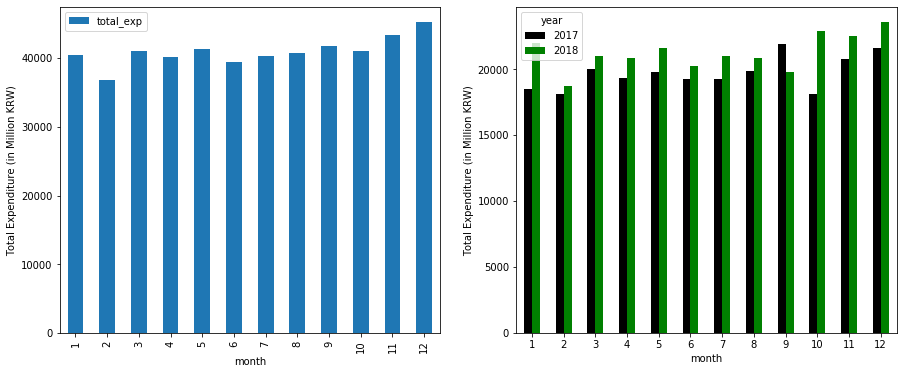

In [204]:
fig, axes = plt.subplots(1,2,figsize=(15,6))

ax1 = exp_month.sort_values(by=['month']).set_index('month').plot.bar(ax = axes[0])
ax1.set_ylabel("Total Expenditure (in Million KRW)")

ax2 = exp_month_yr.groupby(['year','month']).\
                        total_exp.sum().\
                        unstack(0).plot.\
                        bar(ax = axes[1],rot=0, color=['k','g'])
ax2.set_ylabel("Total Expenditure (in Million KRW)")

By each month, it seems there is no visible trend of the expenditure.
However, considering the year from 2017 to 2018, the expenditure always increases except in September.

#### Gender


In [214]:
exp_gender,exp_gender_yr =  create_df_per_year_cat(exp_df,['성별코드'],\
                                               F.sum,'Total_exp','Total_exp')

In [215]:
exp_gender

,성별코드,sum(Total_exp)
0,1,2.392496e+11
1,2,2.522366e+11


In [216]:
exp_gender_yr

,성별코드,year(요양개시일자),sum(Total_exp)
0,1,2017,1.145227e+11
1,1,2018,1.247270e+11
2,2,2017,1.219683e+11
3,2,2018,1.302683e+11


Similar to the months category, I will divide them by 1 million to simplify the visualization. And also, I rename the columns to alphabet and decode the gender code

In [217]:
exp_gender.columns=['Gender','total_exp']
exp_gender = exp_gender.replace({'Gender':gender_code})
exp_gender.total_exp = exp_gender.total_exp / (1000 * 1000)
exp_gender_yr.columns=['Gender','year','total_exp']
exp_gender_yr = exp_gender_yr.replace({'Gender':gender_code})
exp_gender_yr.total_exp = exp_gender_yr.total_exp / (1000 * 1000)

In [218]:
exp_gender

,Gender,total_exp
0,male,239249.648350
1,female,252236.589215


Text(0, 0.5, 'Total Expenditure (in Million KRW)')

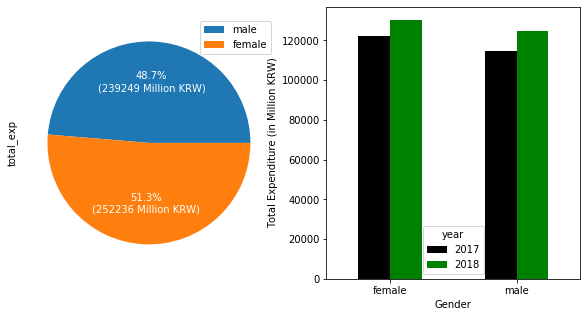

In [221]:
def show_percentage_and_total(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:.0f} Million KRW)".format(pct, absolute)

fig, axes = plt.subplots(1,2,figsize=(10,5))

exp_gender.set_index('Gender').plot.pie(y='total_exp', ax = axes[0],
                         autopct=lambda pct: show_percentage_and_total(pct,exp_gender['total_exp']),
                         textprops=dict(color="w"))

ax = exp_gender_yr.groupby(['year','Gender']).\
                        total_exp.sum().\
                        unstack(0).plot.\
                        bar(ax = axes[1],rot=0, color=['k','g'])
ax.set_ylabel("Total Expenditure (in Million KRW)")

From the visualization,  females spend more money than males for the medicine than men. In 2018, the expenditures on medicine of each group increases. Let's see how this behaviour go for the other groups.

#### Age group

In [210]:
exp_age, exp_age_yr = create_df_per_year_cat(exp_df,['연령대코드'],\
                                               F.sum,'Total_exp','Total_exp')

In [211]:
exp_age.head()

,연령대코드,sum(Total_exp)
0,12,5.675193e+10
1,1,9.190243e+09
2,13,6.271203e+10
3,6,7.859636e+09
4,16,5.415630e+10


In [213]:
exp_age_yr.head()

,연령대코드,year(요양개시일자),sum(Total_exp)
0,13,2018,3.294563e+10
1,7,2018,4.615600e+09
2,1,2017,4.442687e+09
3,3,2017,2.270083e+09
4,6,2018,4.042035e+09


Again, we divide the total expenditure by 1 million and recode the group values.

In [223]:
exp_age.columns=['age_group','total_exp']
exp_age = exp_age.replace({'age_group':age_code})
exp_age.total_exp = exp_age.total_exp / (1000 * 1000)
exp_age_yr.columns=['age_group','year','total_exp']
exp_age_yr = exp_age_yr.replace({'age_group':age_code})
exp_age_yr.total_exp = exp_age_yr.total_exp / (1000 * 1000)

Text(0, 0.5, 'Total Expenditure (in Million KRW)')

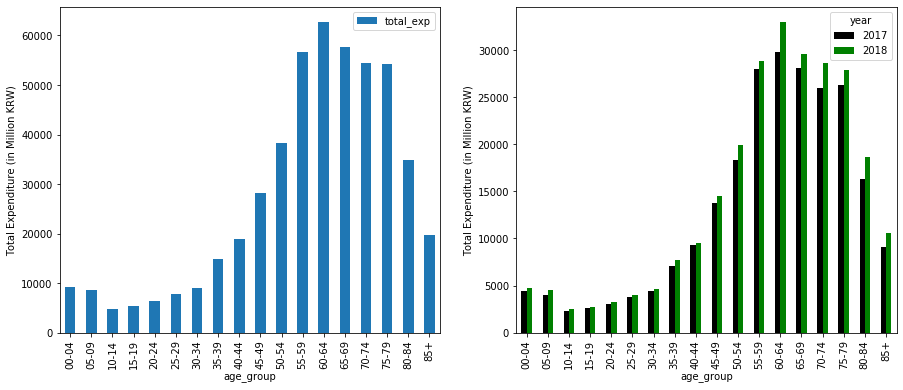

In [228]:
fig, axes = plt.subplots(1,2,figsize=(15,6))

ax1 = exp_age.sort_values(by=['age_group']).set_index('age_group').plot.bar(ax = axes[0])
ax1.set_ylabel("Total Expenditure (in Million KRW)")

ax2 = exp_age_yr.groupby(['year','age_group']).\
                        total_exp.sum().\
                        unstack(0).plot.\
                        bar(ax = axes[1], color=['k','g'])
ax2.set_ylabel("Total Expenditure (in Million KRW)")

From the visualization, people with older ages (40-80s) spend more money than the other age groups. This is may be possible due to the degrading health performance as people get older.

Children spend more money also for medication than teenagers.

In 2018, the expenditures on medicine of each group increases from 2017.


#### Location

In [230]:
exp_loc,exp_loc_yr =  create_df_per_year_cat(exp_df,['시도코드'],\
                                               F.sum,'Total_exp','Total_exp')

In [232]:
exp_loc.head()

,시도코드,sum(Total_exp)
0,11,8.809178e+10
1,29,1.301642e+10
2,42,1.650939e+10
3,30,1.335815e+10
4,28,2.665202e+10


In [233]:
exp_loc_yr.head()

,시도코드,year(요양개시일자),sum(Total_exp)
0,31,2018,4.781179e+09
1,44,2018,1.163344e+10
2,28,2017,1.282840e+10
3,27,2018,1.193982e+10
4,42,2018,8.689715e+09


Again, we divide the total expenditure by 1 million and recode the group values.

In [234]:
exp_loc.columns=['location','total_exp']
exp_loc = exp_loc.replace({'location':city_code})
exp_loc.total_exp = exp_loc.total_exp / (1000 * 1000)
exp_loc_yr.columns=['location','year','total_exp']
exp_loc_yr = exp_loc_yr.replace({'location':city_code})
exp_loc_yr.total_exp = exp_loc_yr.total_exp / (1000 * 1000)

Text(0, 0.5, 'Total Expenditure (in Million KRW)')

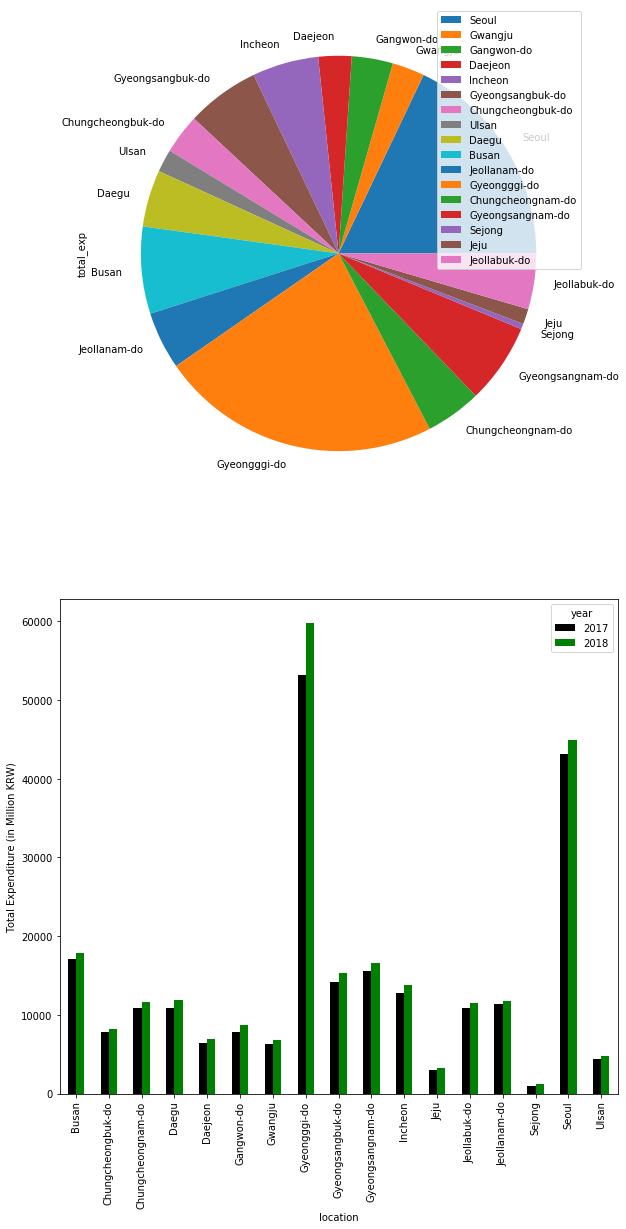

In [237]:
fig, axes = plt.subplots(2,1,figsize=(10,20))

exp_loc.set_index('location').plot.pie(y='total_exp', ax = axes[0])

ax = exp_loc_yr.groupby(['year','location']).\
                        total_exp.sum().\
                        unstack(0).plot.\
                        bar(ax = axes[1], color=['k','g'])
ax.set_ylabel("Total Expenditure (in Million KRW)")

From the visualization,  we see that Gyeonggi and Seoul hold the most expenditure for medicine. This is relatively linear to the number of population of each province in Korea per 2017 and 2018 (source: [2017](http://kostat.go.kr/portal/eng/pressReleases/8/7/index.board?bmode=read&aSeq=370993&pageNo=&rowNum=10&amSeq=&sTarget=&sTxt=), [2018](http://kostat.go.kr/portal/eng/pressReleases/8/7/index.board?bmode=read&aSeq=378503&pageNo=&rowNum=10&amSeq=&sTarget=&sTxt=)).
It would be interesting to go deeper to see each age group average expenditure for each regions.
However, it is beyond this analysis scope.

In 2018, the expenditures on medicine of each group increases. It might be possible that there is an increase in the medicine price from 2017 to 2018.

### 2. Medicine Consumption Case

Special for the medicine, it will be slightly different from the rest.
The analysis will be mainly focus on the top 10 medicines and the other categories will be used as secondary axis.

In [269]:
cons, cons_yr = create_df_per_year_cat(cons_df,['약품일반성분명코드'],\
                                               F.sum,'consumption','consumption')

In [270]:
cons.head()

,약품일반성분명코드,sum(consumption)
0,421001ATB,3.281095e+07
1,111501ATB,2.185550e+07
2,101430ATR,1.998338e+07
3,438901ATB,3.251460e+07
4,186101ATB,2.332938e+07


In [271]:
cons_yr.head()

,약품일반성분명코드,year(요양개시일자),sum(consumption)
0,438901ATB,2017,1.638565e+07
1,530800ASY,2017,1.187300e+07
2,271800ATB,2017,1.212822e+07
3,222901ATB,2018,1.856737e+07
4,271800ATB,2018,1.355411e+07


The total consumption is very large, I will divide them by 1 million to simplify the visualization.

In [272]:
cons.columns=['med_code','consumption']
cons.consumption = cons.consumption / (1000 * 1000)
cons_yr.columns=['med_code','year','consumption']
cons_yr.consumption = cons_yr.consumption / (1000 * 1000)

Text(0, 0.5, 'Total consumption (in Million)')

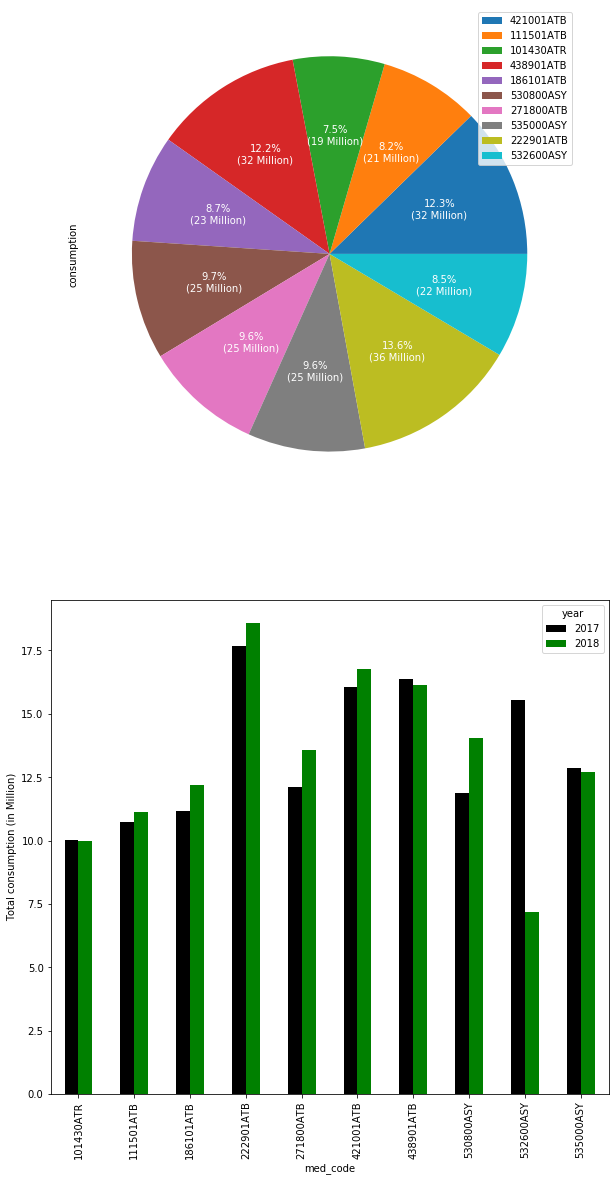

In [274]:
fig, axes = plt.subplots(2,1,figsize=(10,20))
def show_percentage_and_total(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:.0f} Million)".format(pct, absolute)

cons.set_index('med_code').plot.pie(y='consumption', ax = axes[0],\
                                    autopct=lambda pct:\
                                    show_percentage_and_total(pct,cons['consumption']),
                         textprops=dict(color="w"))

ax = cons_yr.groupby(['year','med_code']).\
                        consumption.sum().\
                        unstack(0).plot.\
                        bar(ax = axes[1], color=['k','g'])
ax.set_ylabel("Total consumption (in Million)")

From the visualization, we see that medicine '222901ATB' has the highest share of consumption by 13.6%.

The medicine '530800ASY' has a significant increase from 2017 to 2018. On the other hand, the consumption of medicine '532600ASY' drastically decreases from 2017 to 2018.

Let's see the exact number of the increase and decrease of each medicine consumption.

In [278]:
cons_yr_unstacked = cons_yr.groupby(['year','med_code']).\
                        consumption.sum().\
                        unstack(0)
cons_yr_unstacked[2018] - cons_yr_unstacked[2017]

med_code
101430ATR   -0.031519
111501ATB    0.361447
186101ATB    1.014296
222901ATB    0.908563
271800ATB    1.425896
421001ATB    0.712456
438901ATB   -0.256698
530800ASY    2.170240
532600ASY   -8.370962
535000ASY   -0.172462
dtype: float64

The medicine '530800ASY' has highest increase by 2 million consumption while the consumption of medicine '532600ASY' has the highest decrease by 8 million.

#### Gender


In [280]:
cons_gender,_ =  create_df_per_year_cat(cons_df,['약품일반성분명코드','성별코드'],\
                                               F.sum,'consumption','consumption')

In [281]:
cons_gender

,약품일반성분명코드,성별코드,sum(consumption)
0,438901ATB,2,1.770662e+07
1,421001ATB,1,1.342240e+07
2,421001ATB,2,1.938855e+07
3,530800ASY,2,1.225358e+07
4,186101ATB,1,1.042184e+07
5,186101ATB,2,1.290754e+07
6,535000ASY,1,1.373938e+07
7,222901ATB,2,2.078246e+07
8,111501ATB,2,1.233080e+07
9,535000ASY,2,1.182478e+07


Again, simplifying the numbers and recoding the values

In [282]:
cons_gender.columns=['med_code','gender','consumption']
cons_gender.consumption = cons_gender.consumption / (1000 * 1000)
cons_gender = cons_gender.replace({'gender':gender_code})

In [284]:
cons_gender.head()

,med_code,gender,consumption
0,438901ATB,female,17.706623
1,421001ATB,male,13.422401
2,421001ATB,female,19.388550
3,530800ASY,female,12.253582
4,186101ATB,male,10.421843


Text(0, 0.5, 'Total Consumption (in Million)')

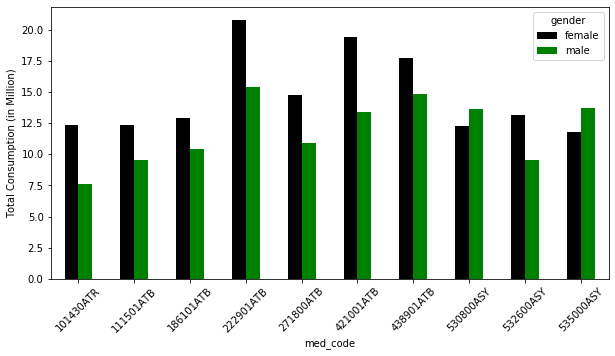

In [291]:
ax = cons_gender.groupby(['gender','med_code']).\
                        consumption.sum().\
                        unstack(0).plot.\
                        bar(rot=45, color=['k','g'],figsize=(10,5))
ax.set_ylabel("Total Consumption (in Million)")

From the visualization, for the most top consumed medicines, females consumes more medication than the males. However, the males consumes medicine '530800ASY' and '535000ASY' more.

#### Age group

In [308]:
cons_age, _ = create_df_per_year_cat(cons_df,['약품일반성분명코드','연령대코드'],\
                                               F.sum,'consumption','consumption')

In [309]:
cons_age.head()

,약품일반성분명코드,연령대코드,sum(consumption)
0,438901ATB,2,1.516813e+06
1,421001ATB,13,3.698511e+06
2,532600ASY,4,5.669760e+05
3,186101ATB,6,1.173321e+06
4,530800ASY,18,9.611000e+03


The consumption for each age group is not very large. Let's divide the consumption by 1 thousand and recode the group values.

In [310]:
cons_age.columns=['med_code','age_group','consumption']
cons_age = cons_age.replace({'age_group':age_code})
cons_age.consumption = cons_age.consumption / (1000)

In [299]:
med_list = cons_age.med_code.unique().tolist()

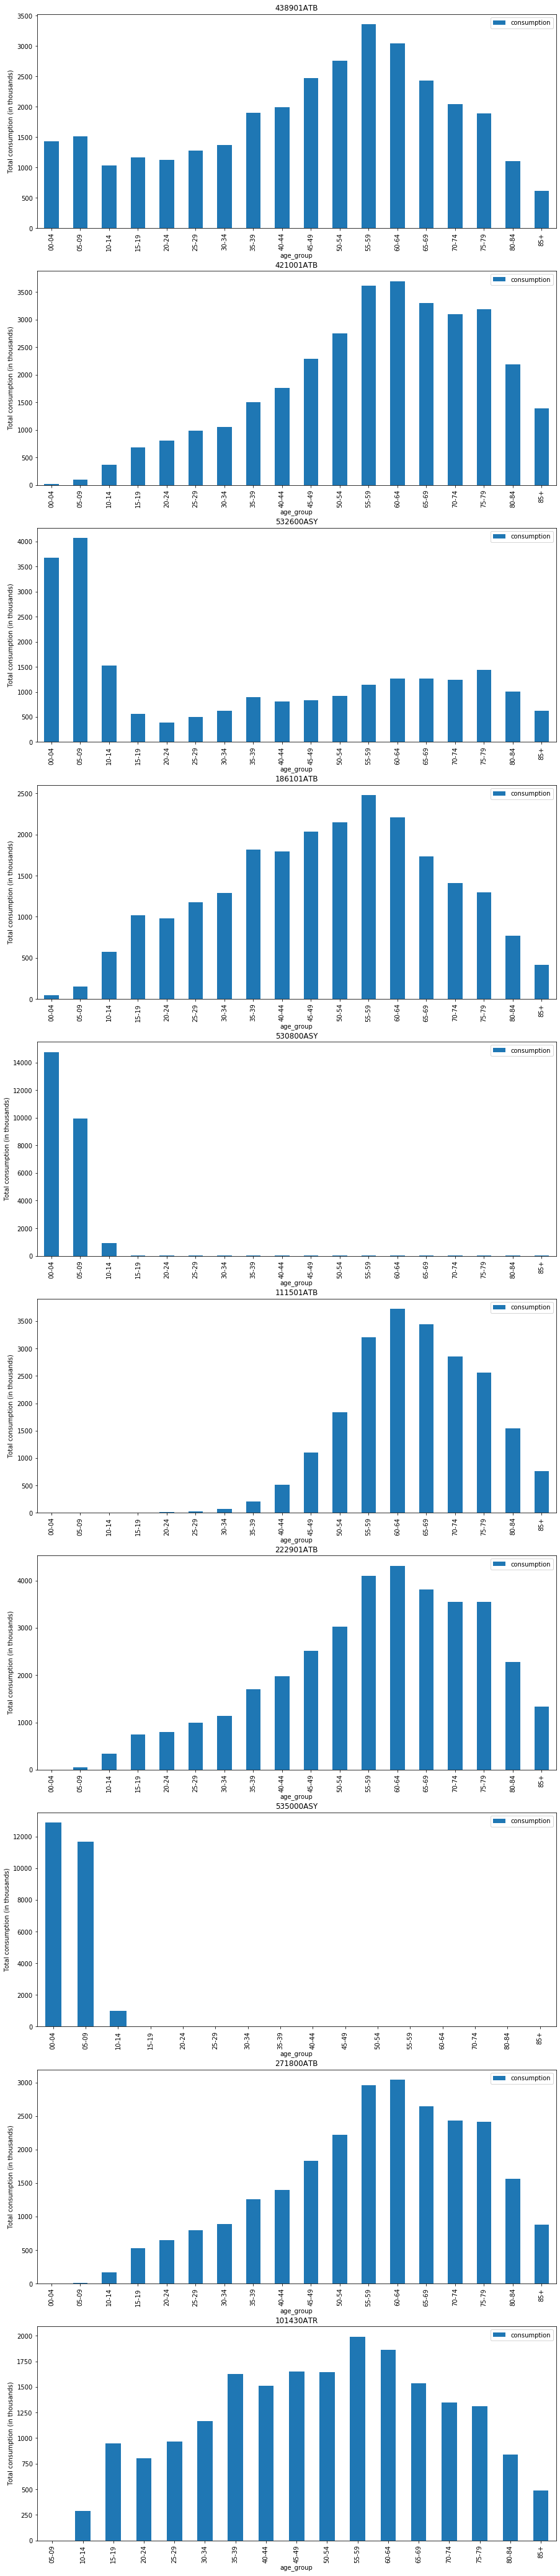

In [319]:
fig, axes = plt.subplots(10,1,figsize=(15,75))

for i in range(len(med_list)):
    cons_age_v = cons_age[cons_age['med_code'] ==  med_list[i]]
    ax1 = cons_age_v.sort_values(by=['age_group']).set_index('age_group').plot.bar(ax = axes[i])
    ax1.set_ylabel("Total consumption (in thousands)")
    ax1.set_title(med_list[i])

From the age group visualization, some age group has more tendencies to consume a specific medicine.
- medicine 438901ATB: more likely consumed by older people, but children and teenagers also consume them
- medicine 421001ATB: more likely consumed by older people, but children does not consume them
- medicine 532600ASY: mostly consumed by children
- medicine 186101ATB: normally distributed, more likely consumed by people in 50s
- medicine 530800ASY: mostly (or only) consumed by children
- medicine 111501ATB: mostly (or only) consumed by adults where age group 60s mostly consume them
- medicine 222901ATB: similar to 111501ATB, mostly (or only) consumed by adults where age group 60s mostly consume them. But, a small group of teenagers seemed to consume them
- medicine 535000ASY: mostly (or only) consumed by children
- medicine 271800ATB: similar to 111501ATB, mostly (or only) consumed by adults where age group 60s mostly consume them. But, a small group of teenagers seemed to consume them
- medicine 222901ATR: similar to 111501ATB, mostly (or only) consumed by adults where age group 60s mostly consume them. But, a small group of teenagers seemed to consume them


The medicines with the same last three letter code show the similarity of the medicine consumption. The medicine whose codes ending with 'ATB' is more likely to be consumed by adult and the ones whose codes ending with ASY is more likely to be consumed by children.

#### Location

In [320]:
cons_loc,_ =  create_df_per_year_cat(cons_df,['약품일반성분명코드','시도코드'],\
                                               F.sum,'consumption','consumption')

In [321]:
cons_loc.head()

,약품일반성분명코드,시도코드,sum(consumption)
0,101430ATR,30,5.984725e+05
1,535000ASY,44,1.308857e+06
2,222901ATB,48,2.289334e+06
3,101430ATR,26,1.378934e+06
4,535000ASY,30,7.639538e+05


In [233]:
exp_loc_yr.head()

,시도코드,year(요양개시일자),sum(Total_exp)
0,31,2018,4.781179e+09
1,44,2018,1.163344e+10
2,28,2017,1.282840e+10
3,27,2018,1.193982e+10
4,42,2018,8.689715e+09


Again, we divide the total expenditure by 1 million and recode the group values.

In [322]:
cons_loc.columns=['med_code','location','consumption']
cons_loc = cons_loc.replace({'location':city_code})
cons_loc.consumption = cons_loc.consumption / (1000 * 1000)

In [323]:
cons_loc

,med_code,location,consumption
0,101430ATR,Daejeon,0.598473
1,535000ASY,Chungcheongnam-do,1.308857
2,222901ATB,Gyeongsangnam-do,2.289334
3,101430ATR,Busan,1.378934
4,535000ASY,Daejeon,0.763954
...,...,...,...
165,111501ATB,Busan,1.385928
166,530800ASY,Daegu,1.979616
167,421001ATB,Jeollanam-do,1.696570
168,222901ATB,Chungcheongbuk-do,1.216875


In [362]:
cons_loc_unstacked = cons_loc.groupby(['med_code','location']).\
                        consumption.sum().\
                        unstack(0)

In [363]:
cons_loc_unstacked.idxmax(axis=1)

location
Busan                421001ATB
Chungcheongbuk-do    421001ATB
Chungcheongnam-do    438901ATB
Daegu                530800ASY
Daejeon              438901ATB
Gangwon-do           222901ATB
Gwangju              222901ATB
Gyeongggi-do         438901ATB
Gyeongsangbuk-do     222901ATB
Gyeongsangnam-do     421001ATB
Incheon              438901ATB
Jeju                 222901ATB
Jeollabuk-do         222901ATB
Jeollanam-do         222901ATB
Sejong               530800ASY
Seoul                222901ATB
Ulsan                530800ASY
dtype: object

From the analysis above, we see that each region has its own most consumed medicine.
- 421001ATB: Busan, Chungcheongbuk-do, Gyeongsangnam-do
- 438901ATB: Chungcheongnam-do, Daejeon, Gyeonggi-do, Incheon
- 530800ASY: Daegu, Sejong, Ulsan
- 222901ATB: Gangwon, Gwangju, Gyeongsangbuk-do, Jeju, Jeollabuk-do,Jeollanam-do, Seoul

### 3. Medication Days Case



In [364]:
med_month, med_month_yr = create_df_per_year_cat(meds_df,[F.month('요양개시일자')],\
                                               F.max,'Med_days','Med_days')

In [365]:
med_month.head()

,month(요양개시일자),max(Med_days)
0,12,450.0
1,1,600.0
2,6,728.0
3,3,840.0
4,5,750.0


In [366]:
med_month_yr.head()

,month(요양개시일자),year(요양개시일자),max(Med_days)
0,7,2018,400.0
1,1,2017,500.0
2,3,2017,840.0
3,6,2018,728.0
4,3,2018,600.0


The days of medication does not need simplification because their value is less than thousands. However, column renaming is required

In [367]:
med_month.columns=['month','days']
med_month_yr.columns=['month','year','days']

Text(0, 0.5, 'Maximum medication days')

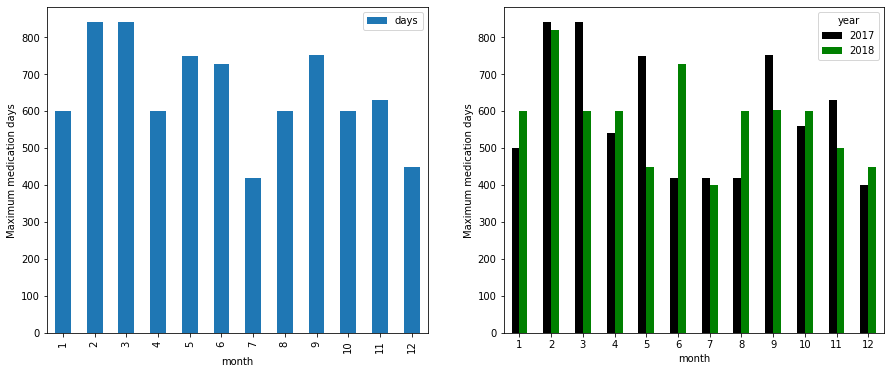

In [368]:
fig, axes = plt.subplots(1,2,figsize=(15,6))

ax1 = med_month.sort_values(by=['month']).set_index('month').plot.bar(ax = axes[0])
ax1.set_ylabel("Maximum medication days")

ax2 = med_month_yr.groupby(['year','month']).\
                        days.sum().\
                        unstack(0).plot.\
                        bar(ax = axes[1],rot=0, color=['k','g'])
ax2.set_ylabel("Maximum medication days")

(To be honest, I am surprised about the number of maximum medication days of the medicines)

By the month trends, the maximum medication days seems get lower in June-July and December-January in each year.

#### Gender


In [371]:
meds_gender,meds_gender_yr =  create_df_per_year_cat(meds_df,['성별코드'],\
                                               F.max,'Med_days','Med_days')

In [372]:
meds_gender

,성별코드,max(Med_days)
0,1,840.0
1,2,840.0


From 2017-2018, each gender may not have any difference in maximum medication days. So, let's just skip its visualization

I rename the columns to alphabet and decode the gender code

In [375]:
meds_gender.columns=['Gender','days']
meds_gender = meds_gender.replace({'Gender':gender_code})
meds_gender_yr.columns=['Gender','year','days']
meds_gender_yr = meds_gender_yr.replace({'Gender':gender_code})


Text(0, 0.5, 'Max. medication days')

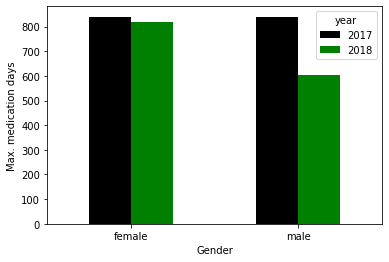

In [382]:
ax = meds_gender_yr.groupby(['year','Gender']).\
                        days.sum().\
                        unstack(0).plot.\
                        bar(rot=0, color=['k','g'])
ax.set_ylabel("Max. medication days")

From the visualization, males tend to have fewer maximum medication days from the females. In 2018, this maximum medication days drops significantly for the males

#### Age group

In [384]:
meds_age, meds_age_yr = create_df_per_year_cat(meds_df,['연령대코드'],\
                                               F.max,'Med_days','Med_days')

In [385]:
meds_age.head()

,연령대코드,max(Med_days)
0,12,840.0
1,1,365.0
2,13,751.0
3,6,420.0
4,16,490.0


In [386]:
meds_age_yr.head()

,연령대코드,year(요양개시일자),max(Med_days)
0,13,2018,420.0
1,7,2018,400.0
2,1,2017,210.0
3,3,2017,360.0
4,6,2018,400.0


Again, I recode the group values.

In [387]:
meds_age.columns=['age_group','days']
meds_age = meds_age.replace({'age_group':age_code})
meds_age_yr.columns=['age_group','year','days']
meds_age_yr = meds_age_yr.replace({'age_group':age_code})

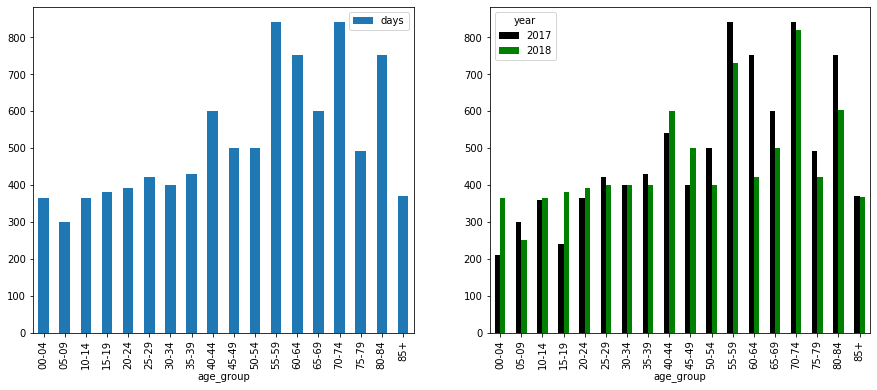

In [388]:
fig, axes = plt.subplots(1,2,figsize=(15,6))

ax1 = meds_age.sort_values(by=['age_group']).set_index('age_group').plot.bar(ax = axes[0])

ax2 = meds_age_yr.groupby(['year','age_group']).\
                        days.max().\
                        unstack(0).plot.\
                        bar(ax = axes[1], color=['k','g'])

From the visualization, people with older ages (50-80s) have more maximum medication days than the other groups.

In 2018, the maximum medication days change does not seem have any trend.


#### Location

In [389]:
meds_loc,meds_loc_yr =  create_df_per_year_cat(meds_df,['시도코드'],\
                                               F.max,'Med_days','Med_days')

In [390]:
meds_loc.head()

,시도코드,max(Med_days)
0,11,840.0
1,29,400.0
2,42,400.0
3,30,400.0
4,28,819.0


In [391]:
meds_loc.head()

,시도코드,max(Med_days)
0,11,840.0
1,29,400.0
2,42,400.0
3,30,400.0
4,28,819.0


Again,  recode the group values.

In [392]:
meds_loc.columns=['location','days']
meds_loc = meds_loc.replace({'location':city_code})
meds_loc_yr.columns=['location','year','days']
meds_loc_yr = meds_loc_yr.replace({'location':city_code})

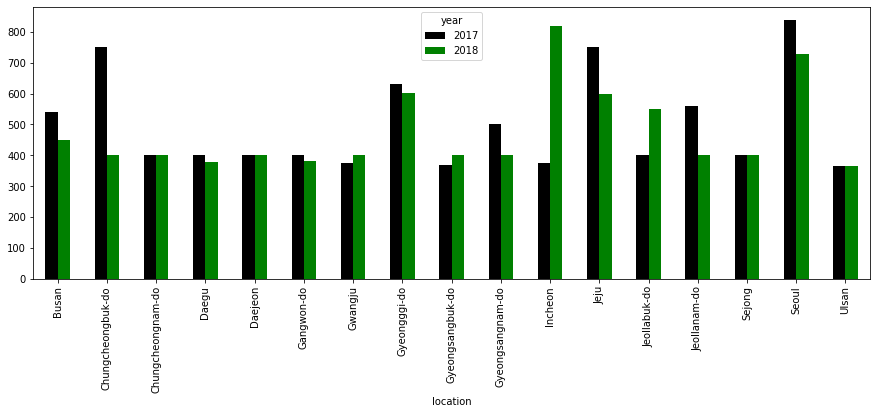

In [400]:
meds_loc_yr.groupby(['year','location']).\
                        days.max().\
                        unstack(0).plot.\
                        bar(color=['k','g'],figsize=(15,5))

From the visualization,  we see that Incheon and Seoul hold the longest medication days. 

Most of the regions has no trend change of maximum medication days. However, I will display the number of the change in the table below.

In [402]:
meds_loc_yr_unstacked = meds_loc_yr.groupby(['year','location']).\
                        days.max().\
                        unstack(0)
meds_loc_yr_unstacked[2018] -meds_loc_yr_unstacked[2017]

location
Busan                -90.0
Chungcheongbuk-do   -351.0
Chungcheongnam-do      0.0
Daegu                -22.0
Daejeon                0.0
Gangwon-do           -20.0
Gwangju               25.0
Gyeongggi-do         -28.0
Gyeongsangbuk-do      30.0
Gyeongsangnam-do    -100.0
Incheon              444.0
Jeju                -150.0
Jeollabuk-do         150.0
Jeollanam-do        -161.0
Sejong                 0.0
Seoul               -112.0
Ulsan                  0.0
dtype: float64